# Simulation example using Area Yield DGP

In [49]:
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm


from lightgbm import LGBMRegressor, LGBMClassifier
from rdrobust import rdrobust

import doubleml as dml
from doubleml.rdd import RDFlex
from doubleml.rdd import datasets

from matplotlib import pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg

import plotly.express as px

In [50]:
%run utils.py

## DGP Parameters

In [51]:
fuzzy = False

cutoff_dist = 0.5
cutoff_improvement = 0.0

params = dict(
    seed=17,
    n_obs=3,
    K=100,
    # origin
    origin_shape='ellipsis',
    origin_a=0.035,
    origin_b=0.01,
    origin_pertubation=0.2,
    # target
    target_center=[1.5, 0],
    target_a=0.6,
    target_b=0.3,
    # action
    action_shift=[1.0, 0],
    action_scale=1.02,
    #action_pertubation=None,
    action_pertubation=[0.001, 0.0006],
    action_drag_share=0.7,
    action_drag_scale=0.7,
    # running
    running_dist_measure='projected',
    running_mea_selection=5,
    # treatment
    treatment_dist=cutoff_dist,
    treatment_improvement=cutoff_improvement,
    treatment_random_share=0.001,
)

## DGP Visualization

In [52]:
data = datasets.dgp_area_yield(**params)

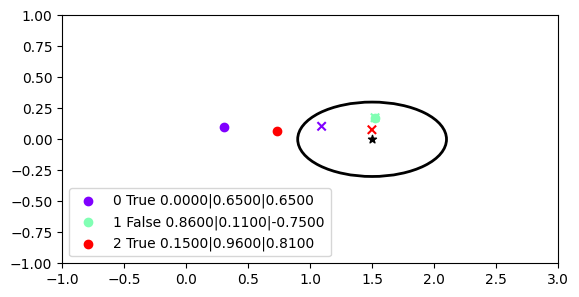

In [53]:

plot_mean_shift(data, params, legend=True)

- Untreated state are the dots
- Treated staes are the crosses
- Red lot was not reworked compared to the other lots
- Target area is indicated by the black ellipse

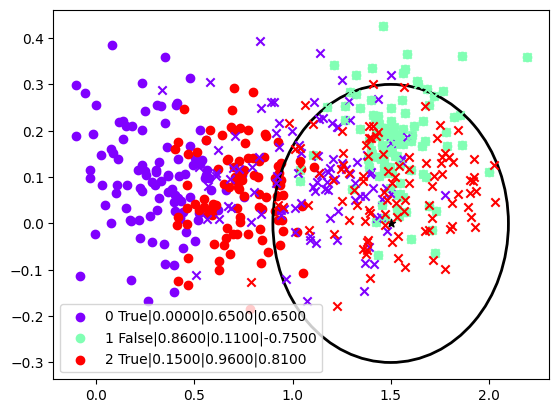

In [54]:
# plot of the individual items of the lots
plot_shift(data, params, legend=True)

In [55]:
data = datasets.dgp_area_yield(**{**params, 'n_obs': 3000})

# improved_points = data['score_improvement'] >= 0.0
# data = {k:v[improved_points] for k,v in data.items()}

fig = px.scatter(x=data['score_distance'] ,y=data['Y'], color=data['D'], labels=dict(x="score_distance", y="Y"), hover_data={'score_improvement': data['score_improvement'], 'score_distance_act': data['score_distance_act'], 'score_improvement_act': data['score_improvement_act']}) 
fig.add_vline(x=params['treatment_dist'])

In [56]:
fig = px.scatter(x=data['score_distance'] ,y=data['score_improvement'], color=data['D'], labels=dict(x="score_distance", y="score_improvement"), hover_data={'score_improvement': data['score_improvement'], 'score_distance_act': data['score_distance_act'], 'score_improvement_act': data['score_improvement_act']}) 
fig.add_vline(x=params['treatment_dist'])
fig.add_hline(y=cutoff_improvement)

In [57]:
fig = px.scatter(x=data['score_distance'] ,y=data['Y0'], color=data['D'], labels=dict(x="score_improvement", y="Y(D=1)"), hover_data={'score_improvement': data['score_improvement'], 'score_distance_act': data['score_distance_act'], 'score_improvement_act': data['score_improvement_act']}) 
fig.add_vline(x=params['treatment_dist'])

## Oracle / Neighborhood Estimator
Estimation is done using bigger sample

In [58]:
n_obs = 10000
selected_params = {**params, 'n_obs': n_obs}
data = datasets.dgp_area_yield(**selected_params)

defiers = data["D"] != data["T"]
print(f"Defier percentage: {defiers.mean()}")

Defier percentage: 0.0061


In [59]:
cutoff = params['treatment_dist']
score = data['score_distance']
ite = data['Y1'] - data['Y0']

kernel_regression_range = 0.3
# remove defiers and restrict to a range around the cutoff
kernel_subset = (score >= cutoff - kernel_regression_range) & (score <= cutoff + kernel_regression_range)
if fuzzy:
    kernel_subset &= ~defiers
kernel_reg = KernelReg(endog=ite[kernel_subset], exog=score[kernel_subset], var_type='c', reg_type='ll')

In [60]:
score_grid = np.linspace(score[kernel_subset].min(), score[kernel_subset].max(), 1000)
predicted_grid, _ = kernel_reg.fit(score_grid)
effect_at_cutoff, _  = kernel_reg.fit(np.array([cutoff]))
print(f"Estimated effect at cutoff: {effect_at_cutoff[0]}")

Estimated effect at cutoff: 0.21502078844855738


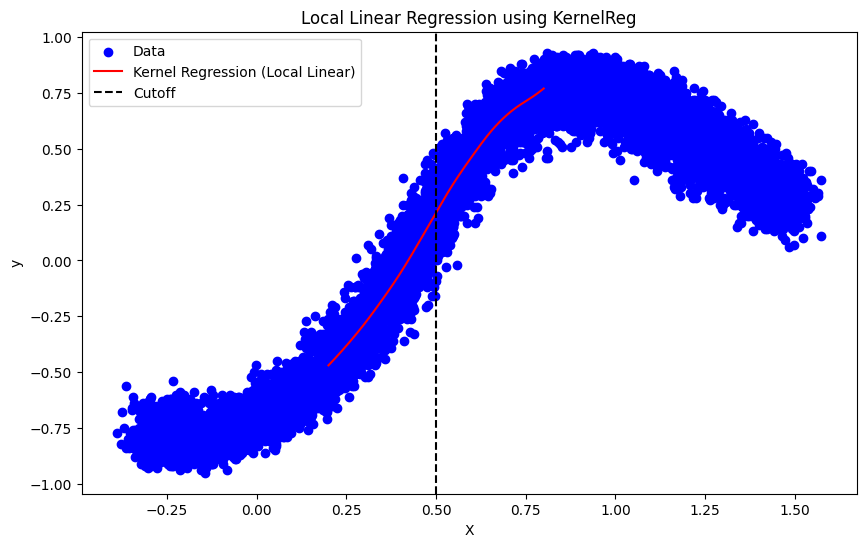

In [61]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(score, ite, color='blue', label='Data')
plt.plot(score_grid, predicted_grid, color='red', label='Kernel Regression (Local Linear)')
plt.xlabel('X')
plt.ylabel('y')
# add vertical line at cutoff
plt.axvline(x=cutoff, color='black', linestyle='--', label='Cutoff')
plt.legend()
plt.title('Local Linear Regression using KernelReg')
plt.show()


In [62]:
treatment_dist = params['treatment_dist']
X1_close = (score[kernel_subset] > treatment_dist - 0.02) & (score[kernel_subset] < treatment_dist + 0.02)
print(f'Neighborhood observations: {X1_close.sum()}')
neighbor_est = data["Y1"][kernel_subset][X1_close].mean() - data["Y0"][kernel_subset][X1_close].mean()
print(f'Neighborhood estimator: {neighbor_est}')
print(f"Local Kernel Regression Estimator: {effect_at_cutoff[0]}")

Neighborhood observations: 210
Neighborhood estimator: 0.2169523809523809
Local Kernel Regression Estimator: 0.21502078844855738


In [63]:
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.linear_model import RidgeCV
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.utils import GlobalRegressor, GlobalClassifier

base_regressors = [
    ('lgbm_regressor', LGBMRegressor(n_estimators=200, learning_rate=0.01, verbose=-1, n_jobs=-1)),
    ('linear_regressor', LinearRegression()),
    ('global_regressor', GlobalRegressor(LinearRegression())),
]

stacking_regressor = StackingRegressor(
    estimators=base_regressors,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

base_classifiers = [
    ('lgbm_classifier', LGBMClassifier(n_estimators=200, learning_rate=0.01, verbose=-1, n_jobs=-1)),
    ('logistic_classifier', LogisticRegression()),
    ('global_classifier', GlobalClassifier(LogisticRegression())),
]

stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

In [64]:
def single_repetition(seed, n_obs=1000, fuzzy=True):
    res_list = []
    selected_params = {**params, 'n_obs': n_obs, 'seed': seed}
    data = datasets.dgp_area_yield(**selected_params)
    score = data["score_distance"]
    Y = data["Y"]
    X = data["X"].reshape(n_obs, -1)
    D = data["D"]

    if fuzzy:
        res = rdrobust(y=Y, x=score, fuzzy=D, covs=X, c=cutoff)
    else:
        res = rdrobust(y=Y, x=score, covs=X, c=cutoff)

    res_list.append({"rep": "r", "method": "linear", "orcl": effect_at_cutoff[0], "orcl_neigh": neighbor_est,
                     "coef": res.coef.loc["Conventional", "Coeff"], "se": res.se.loc["Robust", "Std. Err."], 
                     "2.5 %": res.ci.loc["Robust", "CI Lower"], "97.5 %": res.ci.loc["Robust", "CI Upper"]})
    
    dml_data = dml.DoubleMLData.from_arrays(y=Y, d=D, x=X, s=score)
    rdflex_model = RDFlex(dml_data,
                      ml_g=stacking_regressor,
                      ml_m=stacking_classifier,
                      n_folds=5,
                      n_rep=1,
                      cutoff=cutoff,
                      fuzzy=fuzzy)
    rdflex_model.fit(n_iterations=2)
    res_list.append({"rep": "r", "method": "stacking", "orcl": effect_at_cutoff[0], "orcl_neigh": neighbor_est,
                     "coef": rdflex_model.coef[0], "se": rdflex_model.se[2], 
                     "2.5 %": rdflex_model.confint().loc["Robust", "2.5 %"], "97.5 %": rdflex_model.confint().loc["Robust", "97.5 %"]})

    rdflex_model = RDFlex(dml_data,
                      ml_g=LGBMRegressor(n_estimators=200, learning_rate=0.01, verbose=-1, n_jobs=-1),
                      ml_m=LGBMClassifier(n_estimators=200, learning_rate=0.01, verbose=-1, n_jobs=-1),
                      n_folds=5,
                      n_rep=1,
                      cutoff=cutoff,
                      fuzzy=fuzzy)
    rdflex_model.fit(n_iterations=2)
    res_list.append({"rep": "r", "method": "LGBM", "orcl": effect_at_cutoff[0], "orcl_neigh": neighbor_est,
                     "coef": rdflex_model.coef[0], "se": rdflex_model.se[2], 
                     "2.5 %": rdflex_model.confint().loc["Robust", "2.5 %"], "97.5 %": rdflex_model.confint().loc["Robust", "97.5 %"]})

    return res_list

In [65]:
n_rep = 1

res_list = []
for r in tqdm(range(n_rep), desc="Repetitions", unit="rep"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        single_res = single_repetition(r, n_obs=5000, fuzzy=fuzzy)
        res_list.extend(single_res)

df = pd.DataFrame(res_list)

Repetitions: 100%|██████████| 1/1 [00:32<00:00, 32.03s/rep]


In [66]:
df.head()

,rep,method,orcl,orcl_neigh,coef,se,2.5 %,97.5 %
0,r,linear,0.215021,0.216952,0.193171,0.011146,0.172857,0.216547
1,r,stacking,0.215021,0.216952,0.194842,0.016163,0.162932,0.226291
2,r,LGBM,0.215021,0.216952,0.200388,0.017003,0.163047,0.229697


In [67]:
n_rep = 100

res_list = []
for r in tqdm(range(n_rep), desc="Repetitions", unit="rep"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            single_res = single_repetition(r, n_obs=10000, fuzzy=fuzzy)
            res_list.extend(single_res)
        except Exception as e:
            print(f"An error occurred during repetition {r}: {e}")

df = pd.DataFrame(res_list)

Repetitions: 100%|██████████| 100/100 [43:45<00:00, 26.26s/rep]


In [68]:
df["CI width"] = df["97.5 %"] - df["2.5 %"]
# ci width for method=="linear"
avg_lin_ci_width = df[df["method"] == "linear"]["CI width"].median()
df["rel. CI width"] = df["CI width"] / avg_lin_ci_width

df["centered. coef"] = (df["coef"] - df["orcl"])
df["coverage"] = ((df["2.5 %"] < df["orcl"]) & (df["97.5 %"] > df["orcl"]))

print(f"Emprical Coverage:\n {df.groupby("method")["coverage"].mean()}")
print(20*"-")
print(f"Average relative CI width:\n {df.groupby("method")["rel. CI width"].mean()}")

Emprical Coverage:
 method
LGBM        0.86
linear      0.72
stacking    0.79
Name: coverage, dtype: float64
--------------------
Average relative CI width:
 method
LGBM        1.532707
linear      1.005590
stacking    1.552226
Name: rel. CI width, dtype: float64


In [69]:
df.groupby("method")["CI width"].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
LGBM,100.0,0.045008,0.002965,0.036304,0.043268,0.045021,0.046891,0.052302
linear,100.0,0.029529,0.002918,0.024297,0.027067,0.029365,0.031620,0.036265
stacking,100.0,0.045581,0.003131,0.038911,0.043444,0.045734,0.047404,0.055888


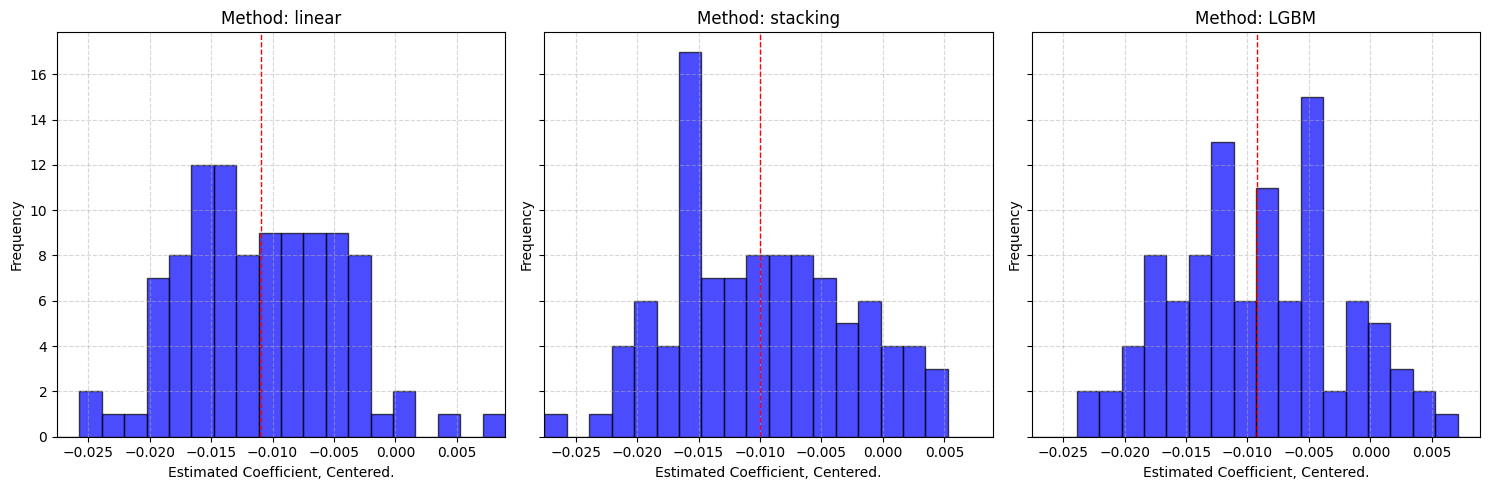

In [70]:
unique_methods = df['method'].unique()

# Anzahl der Methoden (um die Subplots korrekt anzulegen)
n_methods = len(unique_methods)

# Setze die Größe der Gesamtfigur an. Anpassen, falls nötig.
fig, axes = plt.subplots(1, n_methods, figsize=(15, 5), sharey=True)

x_min = max(df['centered. coef'].min(), -2)
x_max = min(df['centered. coef'].max(), 2)
# Erstelle für jede Methode ein Subplot
for i, method in enumerate(unique_methods):
    ax = axes[i] if n_methods > 1 else axes
    subset = df[df['method'] == method]
    
    # Zeichne das Histogramm
    ax.hist(subset['centered. coef'], bins=20, range=(x_min, x_max), alpha=0.7, color='blue', edgecolor='black')

    # mean coef
    mean_coef = subset['centered. coef'].mean()
    ax.axvline(mean_coef, color='red', linestyle='dashed', linewidth=1)
    
    # Achsentitel und Limiten
    ax.set_title(f'Method: {method}')
    ax.set_xlabel('Estimated Coefficient, Centered.')
    ax.set_ylabel('Frequency')
    ax.set_xlim(x_min, x_max)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

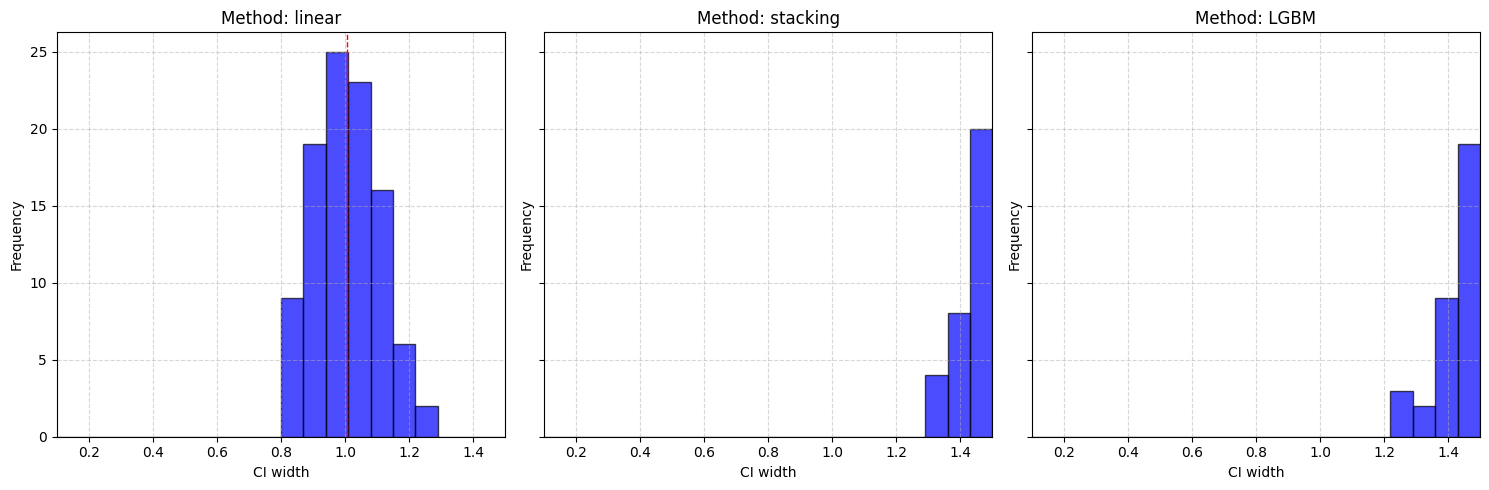

In [71]:
unique_methods = df['method'].unique()

# Anzahl der Methoden (um die Subplots korrekt anzulegen)
n_methods = len(unique_methods)

# Setze die Größe der Gesamtfigur an. Anpassen, falls nötig.
fig, axes = plt.subplots(1, n_methods, figsize=(15, 5), sharey=True)

# Erstelle für jede Methode ein Subplot
for i, method in enumerate(unique_methods):
    ax = axes[i] if n_methods > 1 else axes
    subset = df[df['method'] == method]
    
    # Zeichne das Histogramm
    ax.hist(subset["rel. CI width"], bins=20, range=(0.1, 1.5), alpha=0.7, color='blue', edgecolor='black')
    
    # Mean CI Width und vertikale Linie dafür
    mean_ci_width = subset["rel. CI width"].mean()
    ax.axvline(mean_ci_width, color='red', linestyle='dashed', linewidth=1)
    
    # Achsentitel und Limiten
    ax.set_title(f'Method: {method}')
    ax.set_xlabel('CI width')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0.1, 1.5)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [72]:
df.to_csv("res/results_area_yield.csv")

OSError: Cannot save file into a non-existent directory: 'res'